# Molecular Dynamics Simulations in EMPP 2024
## Part 2


Before we implement all classes, we will first visualize the particles moving in a 2D box. We will use the `matplotlib` library to create an animation of the particles moving in the box. We will also implement periodic boundary conditions, so that particles that leave the box on one side re-enter on the opposite side.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial.distance import cdist

plt.rcParams.update({'font.size': 8,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'axes.labelsize': 10,
                     'axes.titlesize': 10,
                     'xtick.labelsize' : 10,
                     'ytick.labelsize' : 10,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',})

def get_size(w,h):
    return((w/2.54,h/2.54))

## Create a particle array


We will start creating an array of particles in 2D using numpy. Out box will be of size (1,1).

In [91]:
# number of particle per edge
n_side =20

# particle x and y coordinates
x = np.linspace(0.05, 0.95, n_side)
y = np.linspace(0.05, 0.95, n_side)

# meshgrid of them to have points per particle
xx, yy = np.meshgrid(x, y)

# flatten the 2D array
particles = np.vstack([xx.ravel(), yy.ravel()]).T

Just have a look at the array `xx`.

## Create particle velocities

In [92]:
velocities = np.random.normal(scale=0.005, size=(n_side**2, 2))

In [93]:
velocities.shape

(400, 2)

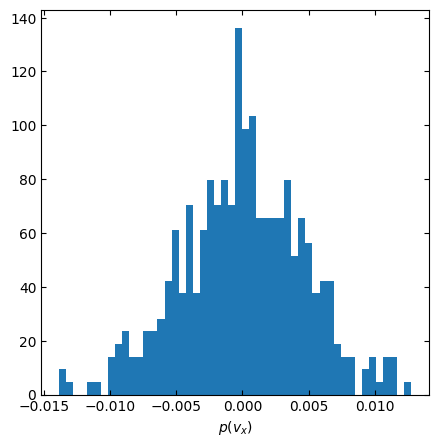

In [94]:
plt.figure(figsize=(5,5))
plt.hist(velocities[:,1],density=True,bins=50)
plt.xlabel(r"$v_x$")
plt.xlabel(r"$p(v_x)$")
plt.show()

## Do one step by hand and apply the boundary conditions

We choose perdiodic boundary conditions. To apply them, the modulo operator `%` is a good choice.


In [95]:

# Update particle positions based on their velocities
particles += velocities

# Apply periodic boundary conditions in x direction (wrap around at 0 and 1)
particles[:, 0] = particles[:, 0] % 1
particles[:, 1] = particles[:, 1] % 1


In [96]:
6 % 2

0

We also need to handle collisions. This requires to calculate all pairwaise distances between all atoms. This could be quite time-consuming.

In [97]:

# Calculate distances between all pairs of particles
distances = cdist(particles, particles)

# Calculate collisions using the upper triangle of the distance matrix
# distances < 2*radius gives a boolean matrix where True means collision
# np.triu takes only the upper triangle to avoid counting collisions twice
collisions = np.triu(distances < 2*radius , 1)


In [98]:
collisions

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Then we need to carry out the collision. We simplify everything assuming a central collision of masses of the same size. This allows us to swap the velocities and to remove the overlap.

In [99]:
# Handle collisions between particles
for i, j in zip(*np.nonzero(collisions)):
    # Exchange velocities between colliding particles (elastic collision)
    velocities[i], velocities[j] = velocities[j], velocities[i].copy()

    # Calculate how much particles overlap
    overlap = 2*radius - distances[i, j]

    # Calculate unit vector pointing from j to i
    direction = particles[i] - particles[j]
    direction /= np.linalg.norm(direction)

    # Move particles apart to prevent overlap
    particles[i] += 0.5 * overlap * direction
    particles[j] -= 0.5 * overlap * direction

This is now carrying out the simulation loop all together handles the drawing. This is the key in this loop. 


Clear the canvas for drawing
```
clear_output(wait=True)
```

Draw the particles 

```
ax.scatter(particles[:, 0], particles[:, 1], s=100, edgecolors='r', facecolors='none')
```


Display the figure

```
display(fig)
plt.pause(0.01)
ax.clear()
```

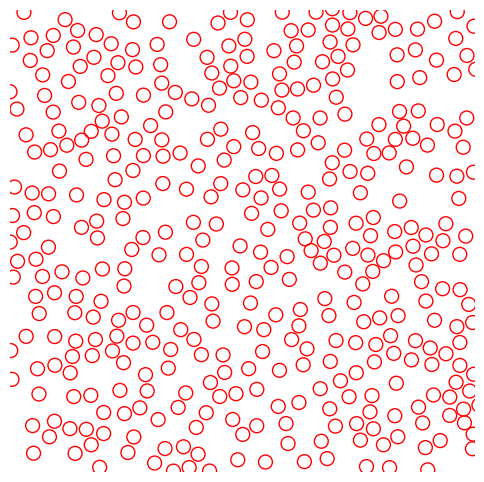

In [100]:
radius = 0.0177
fig, ax = plt.subplots(figsize=(6,6))

n_steps = 200

for _ in range(n_steps):
    clear_output(wait=True)

    # Update particle positions based on their velocities
    particles += velocities
    # Apply periodic boundary conditions in x direction (wrap around at 0 and 1)
    particles[:, 0] = particles[:, 0] % 1
    # Apply periodic boundary conditions in y direction (wrap around at 0 and 1)
    particles[:, 1] = particles[:, 1] % 1
    # Calculate distances between all pairs of particles
    distances = cdist(particles, particles)

    # Calculate collisions using the upper triangle of the distance matrix
    # distances < 2*radius gives a boolean matrix where True means collision
    # np.triu takes only the upper triangle to avoid counting collisions twice
    collisions = np.triu(distances < 2*radius, 1)

    # Handle collisions between particles
    for i, j in zip(*np.nonzero(collisions)):
        # Exchange velocities between colliding particles (elastic collision)
        velocities[i], velocities[j] = velocities[j], velocities[i].copy()

        # Calculate how much particles overlap
        overlap = 2*radius - distances[i, j]

        # Calculate unit vector pointing from j to i
        direction = particles[i] - particles[j]
        direction /= np.linalg.norm(direction)

        # Move particles apart to prevent overlap
        particles[i] += 0.5 * overlap * direction
        particles[j] -= 0.5 * overlap * direction

    ax.scatter(particles[:, 0], particles[:, 1], s=100, edgecolors='r', facecolors='none')


    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")

    display(fig)
    plt.pause(0.01)
    ax.clear()